In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
# from keras.utils import np_utils
# from keras import backend as K
# from tensorflow.examples.tutorials.mnist import input_data
# from keras import regularizers
# from keras.utils import plot_model
# from keras.models import load_model
# import matplotlib.pyplot as plt
from sklearn import preprocessing

E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
import seaborn as sns

from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score


Using TensorFlow backend.


In [3]:
from keras import backend as K
import matplotlib.pyplot as plt

In [4]:
# 设定随机数
seed = 7
np.random.seed(seed)
# 类别个数
num_classes = 3
# 图片大小
lng = 27
# 属性维度
att_d = 4
int_shp = (lng, lng, att_d)

In [5]:
samp_name_b1 = 'E:/20190924_match_pro/classification/data/sb6127_116.csv'
samp_name_b2 = 'E:/20190924_match_pro/classification/data/sb6127_aver_116.csv'
samp_name_b3 = 'E:/20190924_match_pro/classification/data/sb6127_max_116.csv'
samp_name_b4 = 'E:/20190924_match_pro/classification/data/sb6127_min_116.csv'
labe_name    = 'E:/20190924_match_pro/classification/data/lb6127_116.csv'
# 加载数据
print('loading data')
x_train1 = pd.read_csv(samp_name_b1, header=None)
x_train2 = pd.read_csv(samp_name_b2, header=None)
x_train3 = pd.read_csv(samp_name_b3, header=None)
x_train4 = pd.read_csv(samp_name_b4, header=None)
y_train  = pd.read_csv(labe_name, header=None)

loading data


In [6]:
print(x_train1.shape)
print(x_train2.shape)
print(x_train3.shape)
print(x_train4.shape)
print(y_train.shape)

(124176, 729)
(124176, 729)
(124176, 729)
(124176, 729)
(124176, 1)


In [7]:
x_train1 = preprocessing.scale(x_train1)

In [8]:
x_train2 = preprocessing.scale(x_train2)

In [9]:
x_train3 = preprocessing.scale(x_train3)

In [10]:
x_train4 = preprocessing.scale(x_train4)

In [15]:
print('concatting matrax')
x_train = np.concatenate((x_train1,x_train2,x_train3,x_train4),axis=1)

concatting matrax


In [16]:
# 数据维度转换
print('transporting dimention')
x_train = np.array(x_train)
print(x_train.shape)
x_train_all = x_train.reshape(x_train.shape[0], lng, lng, att_d).astype('float32')
print(x_train_all.shape)


transporting dimention
(124176, 2916)
(124176, 27, 27, 4)


(124176, 2916)


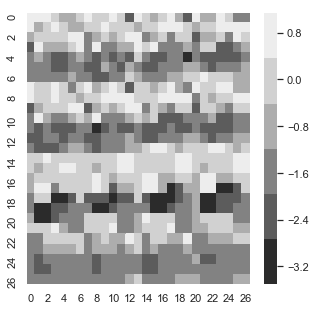

In [17]:
print(x_train.shape)

sns.set(rc={"figure.figsize": (5, 5)})
# abc = sns.choose_colorbrewer_palette("sequential")
abc = sns.color_palette("Greys_r")
ax = sns.heatmap(x_train_all[2,:,:,1],cmap=abc)

In [18]:
y_train = np.array(y_train)
print(y_train.shape)
y_onehot = np.zeros([len(y_train), num_classes])
print(y_onehot.shape)


(124176, 1)
(124176, 3)


In [19]:
# 独热编码
print('encoding one-hot')
y_train = np.array(y_train)
y_onehot = np.zeros([len(y_train), num_classes])
for i in range(len(y_train)) :
    if y_train[i,0] == 1 :
        y_onehot[i, 0] = 1
    if y_train[i,0] == 2 :
        y_onehot[i, 1] = 1
    if y_train[i,0] == 3 :
        y_onehot[i, 2] = 1
y_train = y_onehot

encoding one-hot


(124176, 3)


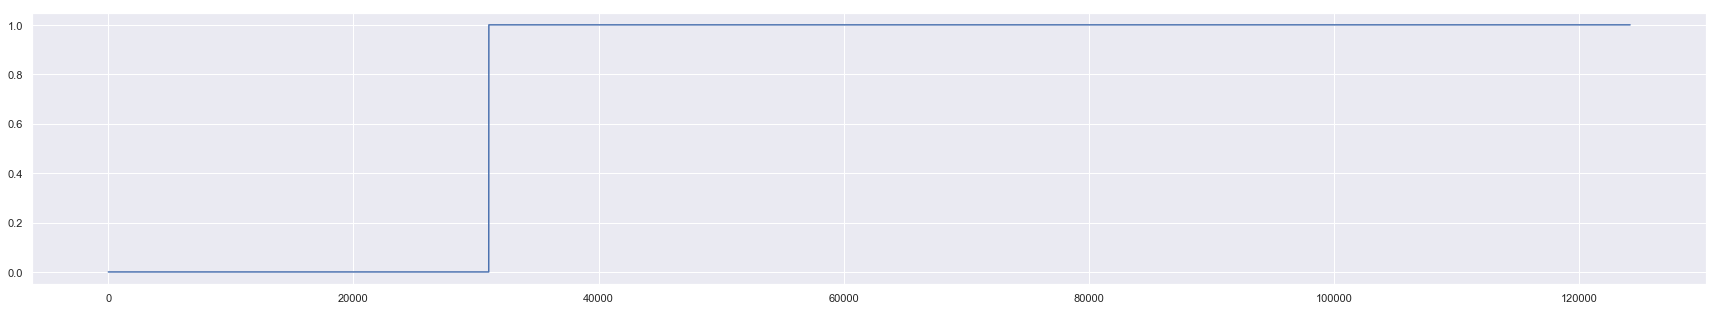

In [20]:
print(y_train.shape)


plt.figure(1, figsize=(30, 5))
plt.plot(y_train[:, 2])

In [21]:
x_valid,x_train = x_train_all[:1000],x_train_all[1000:]
y_valid,y_train = y_onehot[:1000],y_onehot[1000:]

print(x_valid.shape)
print(x_train.shape)

(1000, 27, 27, 4)
(123176, 27, 27, 4)


In [22]:
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        
        
        x_val = self.validation_data[0]
        y_val = self.validation_data[1]
        
#         val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_predict = np.argmax(np.asarray(self.model.predict(x_val)), axis=1)
#         val_targ = self.validation_data[1]
        val_targ = np.argmax(y_val, axis=1)
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
#         _val_recall = recall_score(val_targ, val_predict)
#         _val_precision = precision_score(val_targ, val_predict)
        self.val_f1s.append(_val_f1)
#         self.val_recalls.append(_val_recall)
#         self.val_precisions.append(_val_precision)
#         print('— val_f1: %f — val_precision: %f — val_recall %f' %(_val_f1, _val_precision, _val_recall))
        print(' — val_f1:' ,_val_f1)
        return


In [23]:
def vgg_model():
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu',padding='same', input_shape=int_shp))
    model.add(keras.layers.Conv2D(filters=16, kernel_size=3, activation='relu', padding='same', ))
    model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu',padding='same',))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', ))
    model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='same'))
     
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(2048, activation='relu'))
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    # 编译
    #sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    adam = keras.optimizers.Adam(lr=0.01, decay=0.1)
    
    
    
    def multi_category_focal_loss1(alpha, gamma=2.0):
        """
        focal loss for multi category of multi label problem
        适用于多分类或多标签问题的focal loss
        alpha用于指定不同类别/标签的权重，数组大小需要与类别个数一致
        当你的数据集不同类别/标签之间存在偏斜，可以尝试适用本函数作为loss
        Usage:
         model.compile(loss=[multi_category_focal_loss1(alpha=[1,2,3,2], gamma=2)], metrics=["accuracy"], optimizer=adam)
        """
        epsilon = 1.e-7
        alpha = tf.constant(alpha, dtype=tf.float32)
        #alpha = tf.constant([[1],[1],[1],[1],[1]], dtype=tf.float32)
        #alpha = tf.constant_initializer(alpha)
        gamma = float(gamma)
        def multi_category_focal_loss1_fixed(y_true, y_pred):
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
            y_t = tf.multiply(y_true, y_pred) + tf.multiply(1-y_true, 1-y_pred)
            ce = -tf.log(y_t)
            weight = tf.pow(tf.subtract(1., y_t), gamma)
            
            fl = tf.reduce_sum(tf.multiply(tf.multiply(weight, ce), alpha), reduction_indices=1)
#             fl = tf.matmul(tf.multiply(weight, ce), alpha)
            loss = tf.reduce_mean(fl)
            return loss
        return multi_category_focal_loss1_fixed

    


    def f1(y_true, y_pred):
        def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_true, y_pred):
            """Precision metric.

            Only computes a batch-wise average of precision.

            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

    model.compile(loss=[multi_category_focal_loss1(alpha=[5,5,2], gamma=2)], optimizer='adam', metrics=[f1])
    return model


In [24]:
# 构造并显示模型结构
print('making model')
model = vgg_model()
model.summary()

making model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 16)        592       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0 

In [ ]:
# 调整
# metrics = Metrics()
model.fit(x_train, 
          y_train, 
          validation_data=[x_valid,y_valid], 
          epochs=20, 
          batch_size=500, 
          shuffle=True, 
          verbose=2, 

         )
# print('saving model')
# model.save('E:/20190924_match_pro/classification/model/20191010_vgg_3c_10e_116.h5')

Train on 123176 samples, validate on 1000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
123176/123176 - 105s - loss: 0.4288 - f1: 0.8911 - val_loss: 1.1021 - val_f1: 0.7570
Epoch 2/20
